In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.stats import beta

In [208]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.75)

In [32]:
def _peak(series):
    series = np.array(series)
    m = max(series)
    return np.where(series == m)[0][0]

In [127]:
# Load data
FILELOCATION = "/Users/brendan/Documents/projects/risky_sir/go/data/"

all_data = {
    'low R low var':  'A=2,B=6,T=1000,N=1000,ac=0.0001,ar=0.0016,dl=10.json',
    'low R med var':  'A=1,B=3,T=1000,N=1000,ac=0.0001,ar=0.0016,dl=10.json',
    'low R high var': 'A=0.1,B=0.3,T=1000,N=1000,ac=0.0001,ar=0.0016,dl=10.json',
    'low R control':  'A=-1,B=-1,T=1000,N=1000,ac=0.0002,ar=0.0016,dl=10.json',
    'high R low var': 'A=2,B=6,T=1000,N=1000,ac=0.0001,ar=0.0112,dl=10.json',
    'high R med var': 'A=1,B=3,T=1000,N=1000,ac=0.0001,ar=0.0112,dl=10.json',
    'high R high var':'A=0.1,B=0.3,T=1000,N=1000,ac=0.0001,ar=0.0112,dl=10.json',
    'high R control': 'A=-1,B=-1,T=1000,N=1000,ac=0.0008,ar=0.0016,dl=10.json',
    'uniform':  'A=1,B=1,T=1000,N=1000,ac=0.0001,ar=0.0016,dl=10.json',
}

for key, filename in all_data.items():
    with open(FILELOCATION+filename, "r") as file:
        data = json.loads(file.read())
            # add some meta info that all the time series plots use to standardize: 
    data['peak_times'] = [_peak(infected) for infected in data['Infecteds']]
    data['max_peak'] = max(data['peak_times'])
    data['max_len'] = max([len(infected) for infected in data['Infecteds']]) + data['max_peak']
    data['X'] = [i - data['max_peak'] for i in range(data['max_len'])]
    
    
    
    all_data[key] = data

In [155]:
def plot_SIR(ax, data_label_color, title, xlim=[-40, 40], S=False):
    for data, label, color in data_label_color:
        infecteds = data['Infecteds']
        susceptibles = data['Susceptibles']
        Trials = data['Parameters']['Trials']
        N = data['Parameters']['N']
        max_len, max_peak, peak_times, X = data['max_len'], data['max_peak'], data['peak_times'], data['X']
        avg_infected = np.zeros(max_len)
        avg_susceptible = np.zeros(max_len)
        for t in range(Trials):
            spots_to_prepend = max_peak - peak_times[t]
            spots_to_postpend = max_len - (len(infecteds[t]) + spots_to_prepend)
            avg_infected += np.array([0]*spots_to_prepend + infecteds[t] + [0]*spots_to_postpend)
            avg_susceptible += np.array([N]*spots_to_prepend + susceptibles[t] + [susceptibles[t][-1]]*spots_to_postpend)

        ax.plot(X, avg_infected/Trials, color, label=f'{label}')
        if S:
            ax.plot(X, avg_susceptible/Trials, '--', color, label=f'{label}: susceptible')
    ax.set_xlim(xlim)
    ax.set_title(title)
    ax.legend()

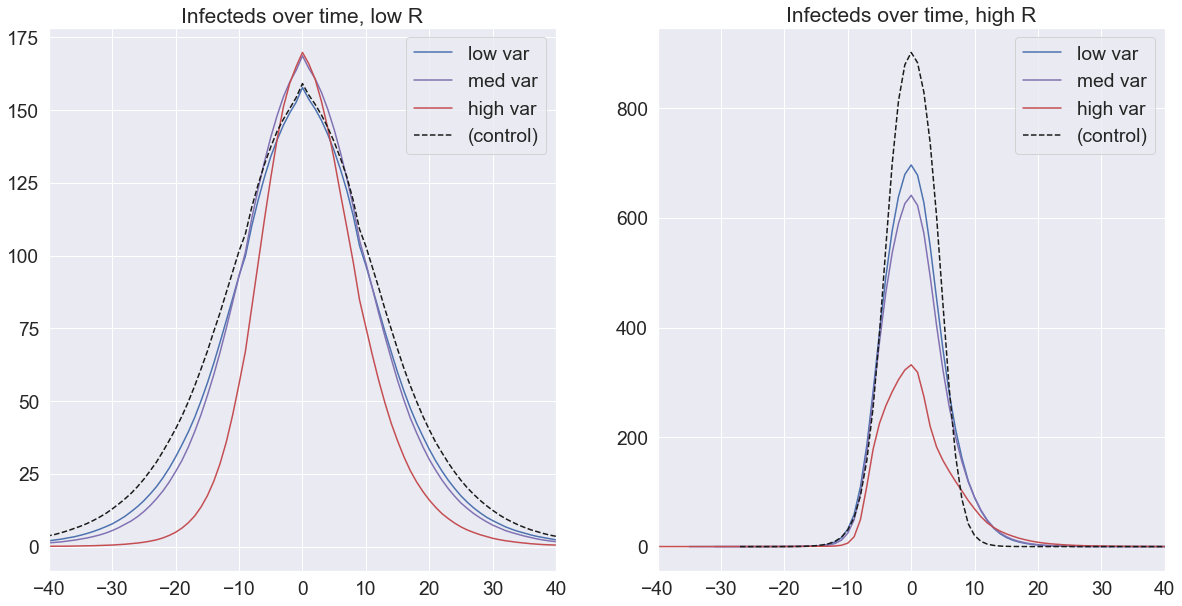

In [209]:
# Results slide 1
results1, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

# low R0, multiple plots
plot_SIR(ax1, [(all_data['low R low var'], 'low var', 'b'),
               (all_data['low R med var'], 'med var', 'm'),
               (all_data['low R high var'], 'high var', 'r'),
              (all_data['low R control'], '(control)', 'k--')], "Infecteds over time, low R")

# high R0, multiple plots
plot_SIR(ax2, [(all_data['high R low var'], 'low var', 'b'),
               (all_data['high R med var'], 'med var', 'm'),
               (all_data['high R high var'], 'high var', 'r'),
              (all_data['high R control'], '(control)', 'k--')], "Infecteds over time, high R")

In [300]:
def plot_infections(ax, data, xlim=[-40, 40], ylim2=[0, 2]):
    """
    rescale the time by peak infection (since these fall so far apart)
    """
    Trials = data['Parameters']['Trials']
    infecteds = data['Infecteds']
    N = data['Parameters']['N']
    alpha_r, alpha_c = data['Parameters']['AlphaR'], data['Parameters']['AlphaC']
    disease_length = data['Parameters']['DiseaseLength']
    A, B = data['Parameters']['A'], data['Parameters']['B']

    
    max_len, max_peak, peak_times, X = data['max_len'], data['max_peak'], data['peak_times'], data['X']
    
    
    # infections:
    
    risky_infections = np.zeros(max_len)
    community_infections = np.zeros(max_len)
    for t, infections in enumerate(data['InfectionEvents']):
        zeros_to_prepend = max_peak - peak_times[t]
        for event in infections:
            if event['WasRiskyEvent']:
                risky_infections[event['EventTime']['Steps'] + zeros_to_prepend] += 1
            else:
                community_infections[event['EventTime']['Steps'] + zeros_to_prepend] += 1

    
    risky_infections /= Trials
    community_infections /= Trials
    
    
    # E[Rt]:
    susceptibles = data['Susceptibles']
    ERtrs = data['ERtrs']
    ERtcs = [[susc*alpha_c*disease_length for susc in susceptible] for susceptible in susceptibles]
    # ERtcs = [[susc*alpha_c/beta for susc in susceptible] for susceptible in susceptibles]

    avg_ERtrs = np.zeros(max_len)
    avg_ERtcs = np.zeros(max_len)
    
    for t in range(Trials):
        zeros_to_prepend = max_peak - peak_times[t]
        initial_ERtr = ERtrs[t][0]
        for z in range(zeros_to_prepend):
            avg_ERtcs[z] += N * alpha_c * disease_length
            # avg_ERtcs[z] += N * alpha_c / beta
            avg_ERtrs[z] += initial_ERtr
        for i in range(len(ERtrs[t])):
            avg_ERtrs[i + zeros_to_prepend] += ERtrs[t][i]
            avg_ERtcs[i + zeros_to_prepend] += ERtcs[t][i]
        
        for j in range(len(ERtrs[t]) + zeros_to_prepend, max_len):
            avg_ERtrs[j] += ERtrs[t][-1]
            avg_ERtcs[j] += ERtcs[t][-1]

    avg_ERtrs /= Trials
    avg_ERtcs /= Trials
    
        ax = ax2.twinx()

    

    ax.set_xlim(xlim)
    ax.plot(X, risky_infections, label="risky infections")
    ax.plot(X, community_infections, label="community infections")
    ax.plot(X, risky_infections + community_infections, label="all infections")
    ax.set_xlabel('time steps')
    ax.set_ylabel('daily infections')
    #plt.title('daily new infections')
    
    ax2.set_ylim(ylim2)
    ax2.grid(False)
    
        
    ax2.plot(X, avg_ERtrs, '-.', label='risky spread Rt')
    ax2.plot(X, avg_ERtcs, '-.', label='community spread Rt')
    ax2.plot(X, avg_ERtrs + avg_ERtcs, '-.', label='total Rt')
    ax2.set_ylabel('infections/infection')
    
    
    ax.legend()


AttributeError: 'AxesSubplot' object has no attribute 'set_yaxis'

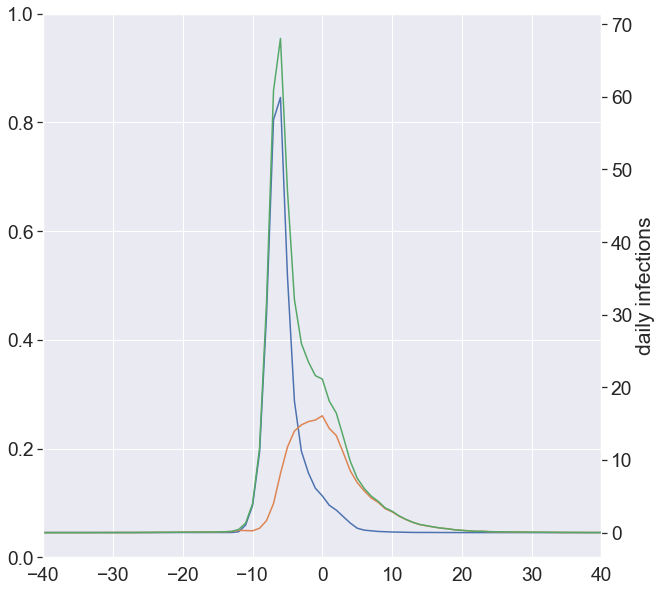

In [301]:
# Results slide 2
results2, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_infections(ax, all_data['high R high var'], ylim2=[0, 10])


In [227]:
def plot_riskyness_distribution(ax, data):
    a, b = data['Parameters']['A'], data['Parameters']['B']
    x = np.linspace(0, 1, 100)
    if (a, b) == (-1, -1):
        y = x*0
    else:
        y = beta.pdf(x, a, b)
    ax.plot(x, y)
    ax.fill_between(x, y, hatch='/')
    ax.set_ylim([0, 5])
    ax.set_title(f'A={a}, B={b}')

In [285]:
def Rfinal_hist(ax, datas, title=''):
    # histogram of final R
    ax.hist(data['FinalRs'], bins=40)
    ax.set_title(title)
    ax.set_xlabel('time')
    ax.set_xlim([0, 1000])
    ax.set_ylim([0, 1000])
    ax.set_ylabel('Final Recovered')

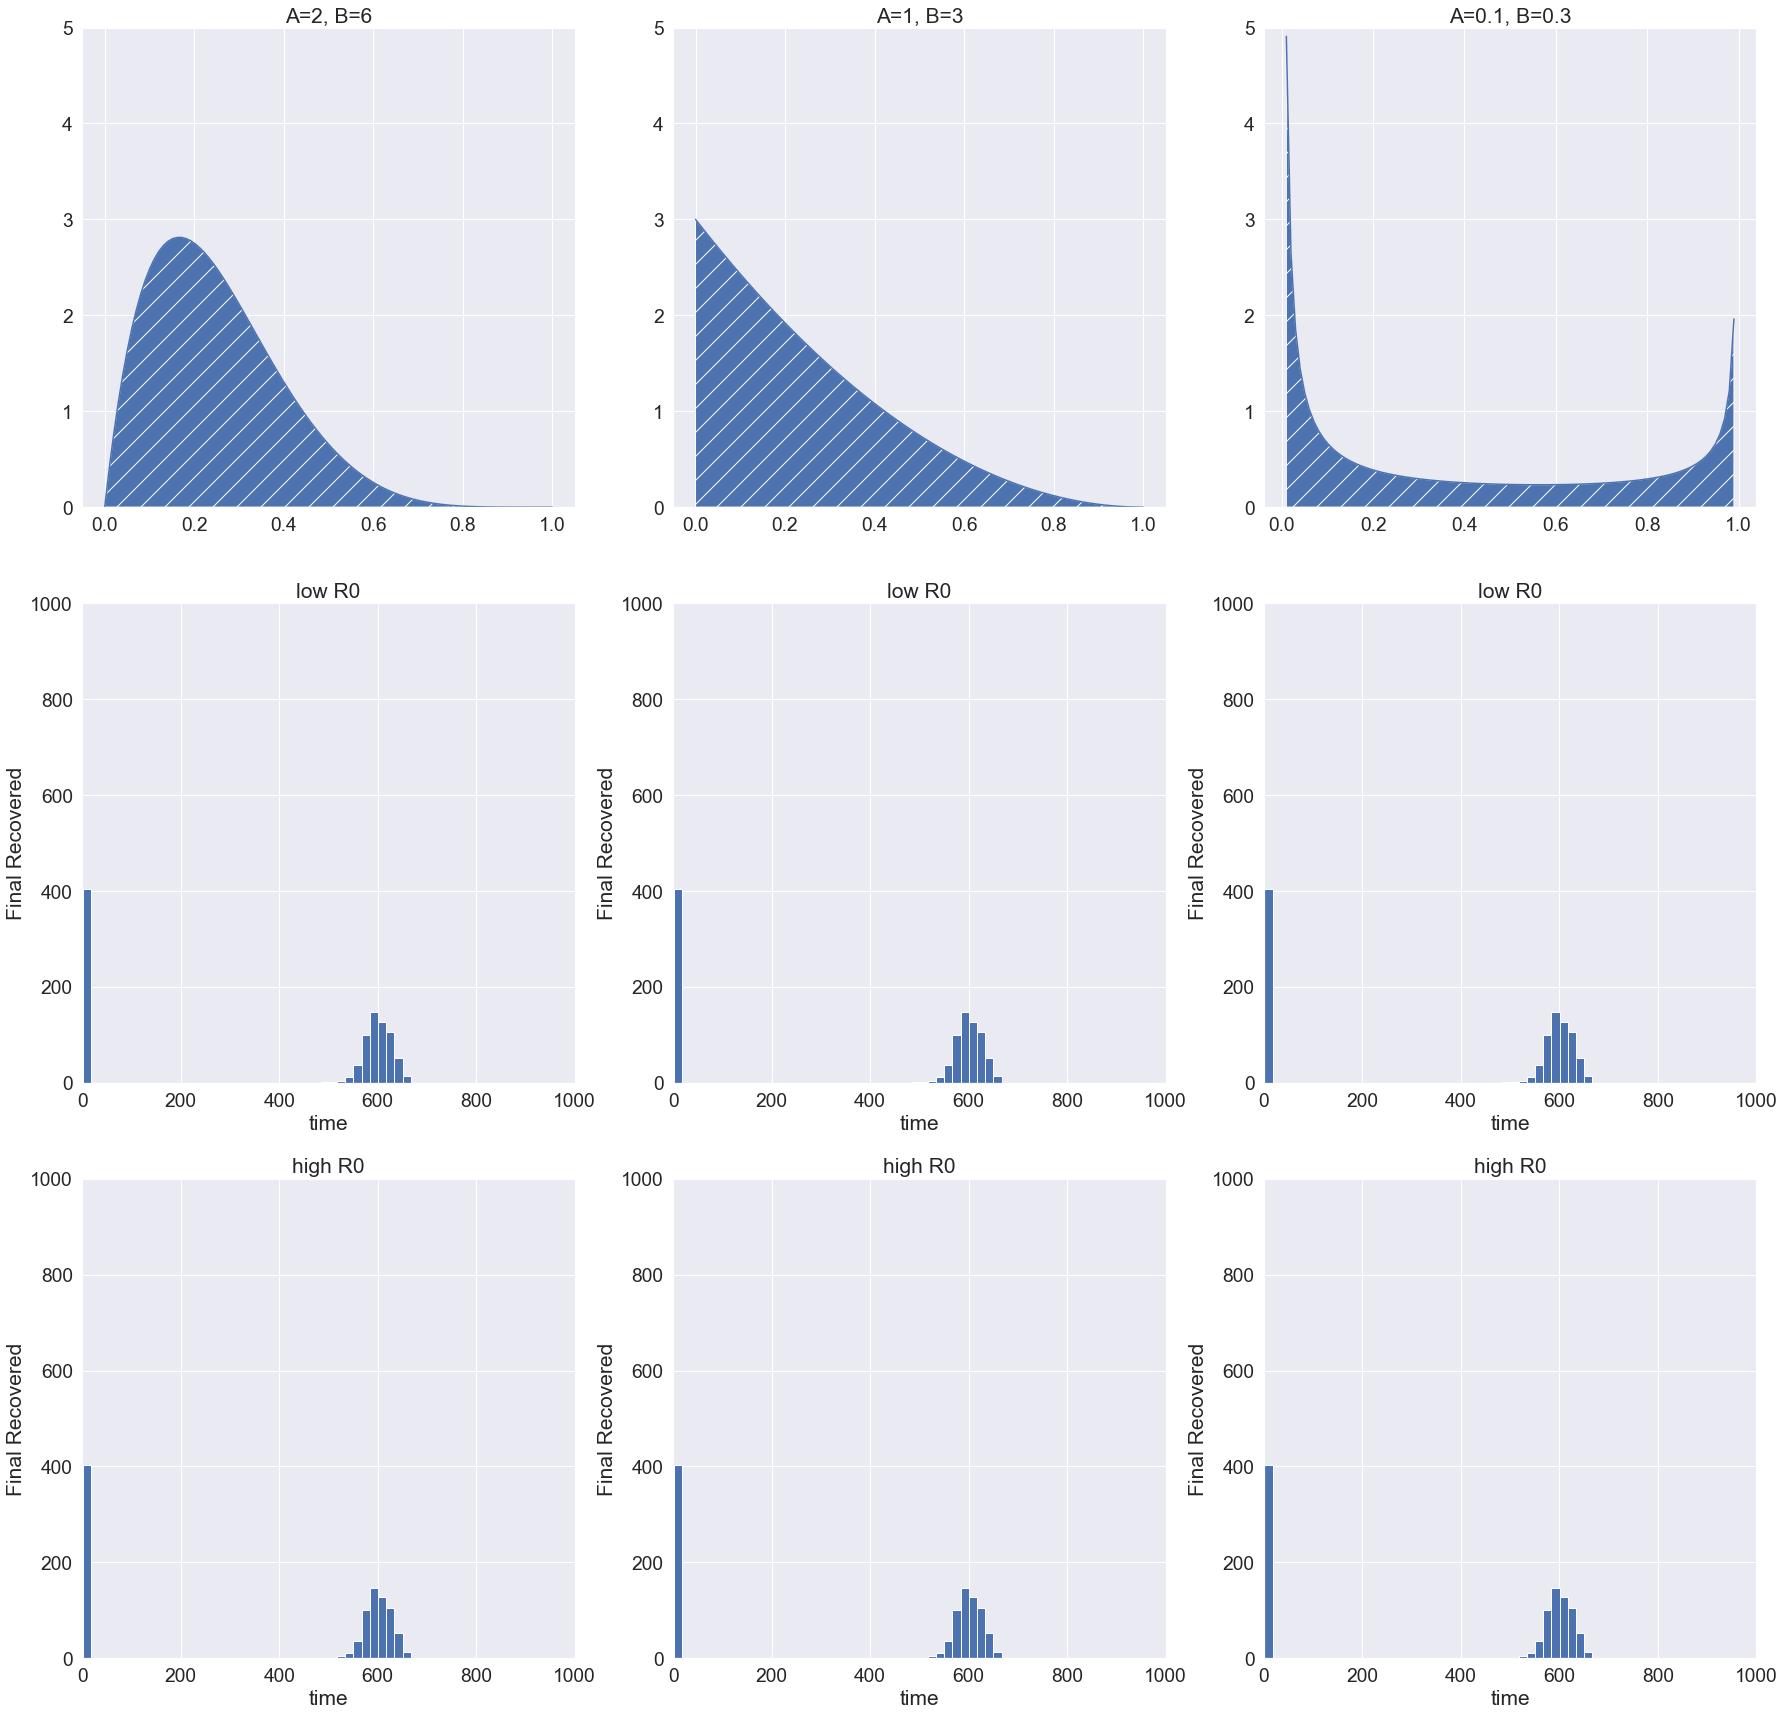

In [286]:
# Results slide 3
results3, [[ax1, ax2, ax3],
           [ax4, ax5, ax6],
           [ax7, ax8, ax9]] = plt.subplots(3, 3, figsize=(30, 30))

plot_riskyness_distribution(ax1, all_data['low R low var'])
plot_riskyness_distribution(ax2, all_data['low R med var'])
plot_riskyness_distribution(ax3, all_data['low R high var'])

Rfinal_hist(ax4, all_data['low R low var'], title='low R0')
Rfinal_hist(ax5, all_data['low R med var'], title='low R0')
Rfinal_hist(ax6, all_data['low R high var'], title='low R0')

Rfinal_hist(ax7, all_data['high R low var'], title='high R0')
Rfinal_hist(ax8, all_data['high R med var'], title='high R0')
Rfinal_hist(ax9, all_data['high R high var'], title='high R0')


In [253]:
def plot_chance_of_being_infected(ax, data, xlim=[-40, 40]):
    """
    Plots chance of being infected in a single day.
    Via risky action,
    and via community spread.
    
    TODO -
    plot for different p values? p=1, 0.8, 0.6, etc.
    Cumulative plot would be very cool too (chance of having been infected by each source up to now)
    If converted to log scale, would be simply additive in a nice way
    """
    Trials = data['Parameters']['Trials']
    alpha_r = data['Parameters']['AlphaR']
    alpha_c = data['Parameters']['AlphaC']
    infecteds = data['Infecteds']
    risky_risks = data['RiskyRisks']
    
    # we can just compute these directly from knowing I at every time step:
    community_risks = [
        [(1 - (1 - alpha_c)**I) for I in infected] for infected in infecteds
    ]

    max_len, max_peak, peak_times, X = data['max_len'], data['max_peak'], data['peak_times'], data['X']

    avg_risky_risk, avg_community_risk = np.zeros(max_len), np.zeros(max_len)
    # realign both 2d arrays of risks:
    for t in range(Trials):
        zeros_to_prepend = max_peak - peak_times[t]
        for i in range(len(risky_risks[t])):
            avg_risky_risk[i + zeros_to_prepend] += risky_risks[t][i]
            avg_community_risk[i + zeros_to_prepend] += community_risks[t][i]
    
    
    avg_risky_risk /= Trials
    avg_community_risk /= Trials
    
    ax.plot(X, avg_risky_risk, label='via taking risky action (with p=1)')
    ax.plot(X, avg_community_risk, label='via community risk')
    ax.set_xlim(xlim)
    ax.set_xlabel('time')
    # plt.plot(ratio, label='scaled diff', linestyle='-.')
    ax.legend()
    ax.set_title('daily chance of being infected')

In [254]:
def imshow_events(ax, data, mag=20):
    """
    Caches it on the data object.
    """
    if 'space' in data:
        space = data['space']
    else:
        flat = [item for l in data['InfectionEvents'] for item in l]
        events = pd.DataFrame(pd.json_normalize(flat))
        N = data['Parameters']['N']
        space = np.zeros((N//mag + 1, N//mag + 1))
        for _, event in events.iterrows():
            r = int(np.floor(event['InfecteeRiskyness'] * (N//mag)))
            #t = min(event['EventTime.Steps']//2, N//mag-1)
            t = (N - event['EventTime.Succeptible'])//mag
            space[r, t] += 1
        data['space'] = space
    ax.grid(False)
    im = ax.imshow(space)
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('later –>')
    ax.set_ylabel('lower riskyness –>')


/var/folders/f0/jtfp47nd0h74_sbtnbwhqzgm0000gn/T/ipykernel_43775/4213034773.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax=ax)


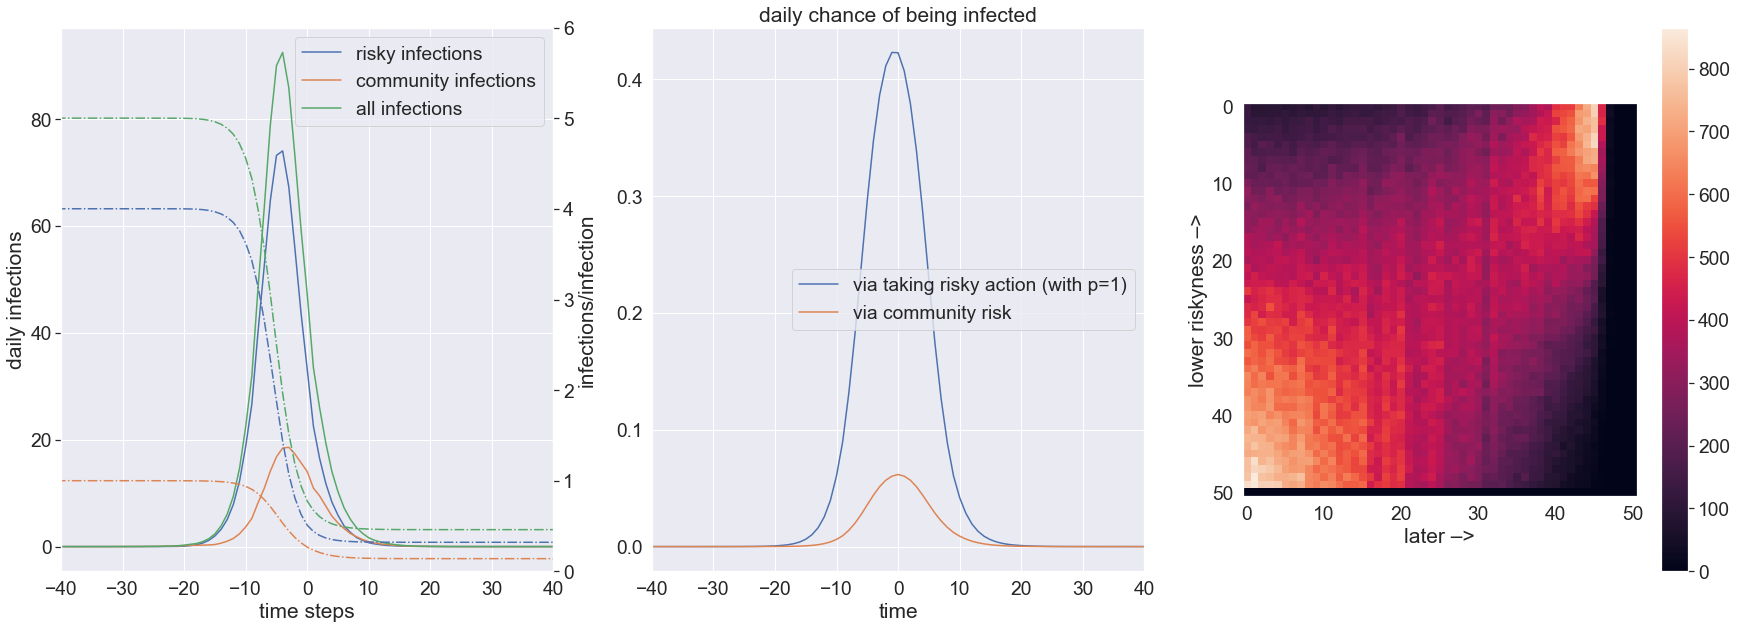

In [271]:
# Results slide 4
results4, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(30, 10))

plot_infections(ax1, all_data['uniform'], ylim2=[0, 6])

plot_chance_of_being_infected(ax2, all_data['uniform'])

imshow_events(ax3, all_data['uniform'])


Text(0, 0.5, 'runs')

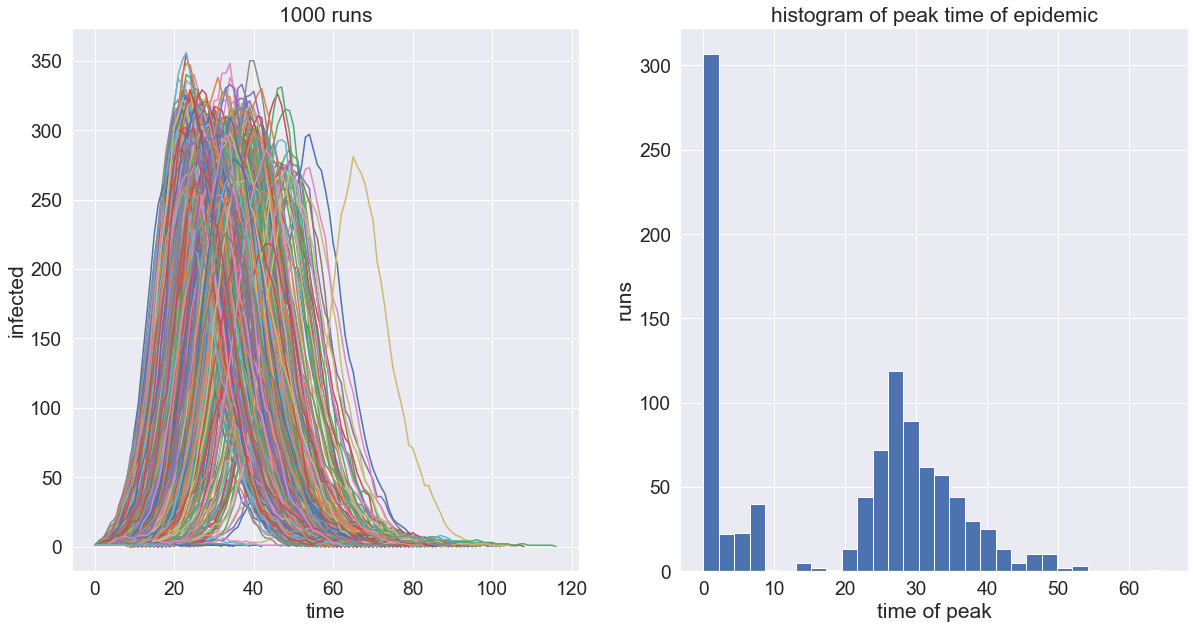

In [270]:
# results 0

results0, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

data = all_data['low R high var']
for inf in data['Infecteds']:
    ax1.plot(inf)
    ax1.set_xlabel('time')
    ax1.set_ylabel('infected')
    ax1.set_title('1000 runs')



ax2.hist([_peak(series) for series in data['Infecteds']], bins=30)
ax2.set_title('histogram of peak time of epidemic')
ax2.set_xlabel('time of peak')
ax2.set_ylabel('runs')
    
